# EXAMEN SERIES TEMPORALES

## Aitor Larrinoa Rementería
### Máster en Data Science
### Curso 2021-2022


## Librerías

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Lectura de los datos

In [49]:
datos_horarios = pd.read_excel("/Users/aitor/Desktop/Máster Ciencia de Datos/Series temporales/Series-temporales/data/EXAM/DemandaEnergia.xlsx",
             sheet_name=0)
datos_horarios = datos_horarios.drop(["Region", "UTC time", "Time zone"], axis=1)
datos_horarios

,Local date,Local hour,Local time,D
0,2015-07-01,1,2015-07-01 01:00:00,38210
1,2015-07-01,2,2015-07-01 02:00:00,35171
2,2015-07-01,3,2015-07-01 03:00:00,33243
3,2015-07-01,4,2015-07-01 04:00:00,31955
4,2015-07-01,5,2015-07-01 05:00:00,31199
...,...,...,...,...
56267,2021-11-30,11,2021-11-30 11:00:00,29068
56268,2021-11-30,12,2021-11-30 12:00:00,28769
56269,2021-11-30,13,2021-11-30 13:00:00,29180
56270,2021-11-30,14,2021-11-30 14:00:00,29719


In [44]:
datos_diarios = pd.read_excel("/Users/aitor/Desktop/Máster Ciencia de Datos/Series temporales/Series-temporales/data/EXAM/DemandaEnergia.xlsx",
             sheet_name=1)
datos_diarios.dtypes

Region                object
Local date    datetime64[ns]
Time zone             object
D                      int64
dtype: object

In [45]:
datos_diarios.index =  datos_diarios["Local date"]
datos_diarios = datos_diarios.drop(["Region", 'Time zone', "Local date"], axis=1)
datos_diarios

,D
Local date,
2015-07-01,978699
2015-07-02,962751
2015-07-03,887079
2015-07-04,830874
2015-07-05,791310
...,...
2021-11-26,625052
2021-11-27,622892
2021-11-28,622017


Calculamos la suma de todas las horas por cada uno de los días para comprobar que efectivamente los datos horarios y diarios son iguales

In [52]:
datos_horarios.groupby("Local date").sum()

,Local hour,D
Local date,,
2015-07-01,300,978699
2015-07-02,300,962751
2015-07-03,300,887079
2015-07-04,300,830874
2015-07-05,300,791310
...,...,...
2021-11-26,300,625052
2021-11-27,300,622892
2021-11-28,300,622017


Vemos que el último registro no coincide. Luego, deberemos hacer algo.

Graficamos la serie temporal de demanda eléctrica diaria

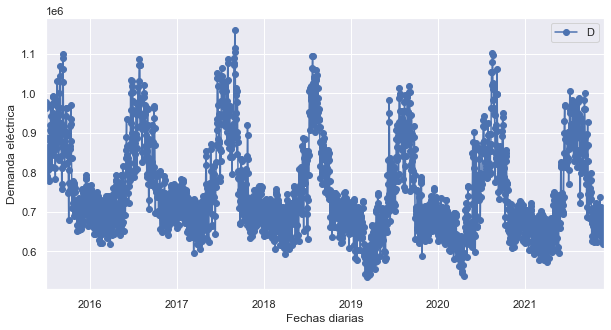

In [48]:
sns.set(rc = {"figure.figsize":(10,5)}) # Definimos el tamaño de la imagen
ax = datos_diarios.plot(marker = 'o', linestyle = '-')
ax.set_ylabel("Demanda eléctrica") # Añadimos título al eje y 
ax.set_xlabel("Fechas diarias"); # Añadimos título al eje x
plt.savefig("Demanda_energia_diaria.png", dpi=300, bbox_inches='tight')

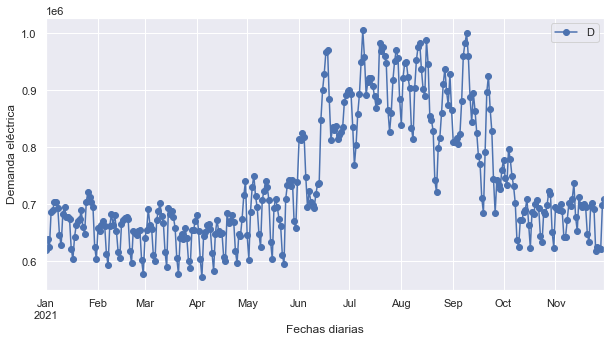

In [51]:
sns.set(rc = {"figure.figsize":(10,5)}) # Definimos el tamaño de la imagen
ax = datos_diarios["2021":].plot(marker = 'o', linestyle = '-')
ax.set_ylabel("Demanda eléctrica") # Añadimos título al eje y 
ax.set_xlabel("Fechas diarias"); # Añadimos título al eje x
plt.savefig("Demanda_energia_diaria_2021-.png", dpi=300, bbox_inches='tight')